In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [4]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import DefaultInteraction
from june.infection import Infection
from june.infection.symptoms import SymptomsConstant
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries
from june.groups.leisure import Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.seed import Seed
from june import paths
from june.logger.read_logger import ReadLogger
from june.infection.infection import InfectionSelector

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [5]:
%%time
geography = Geography.from_file({
                                "msoa":  ["E02001720",
                                          "E00088544", 
                                          "E02002560", 
                                          "E02002559"]
                                }
                                )

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.cemeteries = Cemeteries()
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
demography = Demography.for_geography(geography)
world = World(geography, demography, include_households=True,
             include_commute=True)
world.cinemas = Cinemas.for_geography(geography)
world.pubs = Pubs.for_geography(geography)
world.groceries = Groceries.for_super_areas(geography.super_areas,
                                            venues_per_capita=1/500)

populating the world's geography with the specified demography...
CPU times: user 25.8 s, sys: 937 ms, total: 26.7 s
Wall time: 26.8 s


### If it took a long time to run the previous command, it might be a good idea to save the world in a pickle object to reuse it later.

In [6]:
#world.to_pickle("world.pkl")

If we would like to load the world we saved, we just do

In [7]:
#world = World.from_pickle("world.pkl")

you have now a beautiful pre-pandemic world. 

# Adding the infection

Now, you can play around with different models of infections. The building blocks for an infection are: Transmission and Symptoms. For now, only SymptomsConstant and TransmissionConstant are in a state to be used.

In [8]:
#selector_config = paths.configs_path / "defaults/infection/InfectionConstant.yaml"

selector = InfectionSelector.from_file()

In [9]:
selector

# Adding the interaction

In [10]:
interaction = DefaultInteraction.from_file(selector=selector)

Beta are the intensities of the interaction taking place at the different groups

In [11]:
interaction.beta

{'box': 1,
 'pub': 1,
 'grocery': 1,
 'cinema': 1,
 'commute_unit': 1,
 'commute_city_unit': 1,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 1.0,
 'school': 1.0,
 'household': 1.0}

to modify these, simply do

In [12]:
interaction.beta['household'] *= 2

In [13]:
interaction.beta

{'box': 1,
 'pub': 1,
 'grocery': 1,
 'cinema': 1,
 'commute_unit': 1,
 'commute_city_unit': 1,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 1.0,
 'school': 1.0,
 'household': 2.0}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [14]:
interaction.alpha

2.0

In [15]:
interaction.alpha /= 2

In [16]:
interaction.alpha

1.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [17]:
seed = Seed(world.super_areas, selector,)

In [18]:
n_cases = 500
seed.unleash_virus(n_cases) # play around with the initial number of cases

# Run the simulation

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [19]:
CONFIG_PATH = "../configs/config_example.yaml"

simulator = Simulator.from_file(
     world, interaction, selector, 
    config_filename = CONFIG_PATH
)

In [20]:
# %%time
simulator.run()

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [48]:
import pandas as pd

In [44]:
read = ReadLogger()

In [45]:
hospitals_df = read.load_hospital_capacity()

In [46]:
hospitals_df

,time_stamp,id,coordinates,n_patients,n_patients_icu
0,2020-03-10T10:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[0, 0]","[0, 0]"
1,2020-03-10T12:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[0, 0]","[0, 0]"
2,2020-03-11T00:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[0, 0]","[0, 0]"
3,2020-03-11T10:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[0, 0]","[0, 0]"
4,2020-03-11T12:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[0, 0]","[0, 0]"
...,...,...,...,...,...
77,2020-04-07T12:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[336, 1153]","[336, 1153]"
78,2020-04-08T00:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[336, 1181]","[336, 1181]"
79,2020-04-08T10:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[336, 1174]","[336, 1174]"
80,2020-04-08T12:00:00.000000,"[0, 1]","[[54.5435676574707, -1.5911372900009155], [54....","[336, 1197]","[336, 1197]"


In [49]:
hospitals_df.apply(pd.Series.explode)

,time_stamp,id,coordinates,n_patients,n_patients_icu
0,2020-03-10T10:00:00.000000,0,"[54.5435676574707, -1.5911372900009155]",0,0
0,2020-03-10T10:00:00.000000,1,"[54.5435676574707, -1.5911372900009155]",0,0
1,2020-03-10T12:00:00.000000,0,"[54.5435676574707, -1.5911372900009155]",0,0
1,2020-03-10T12:00:00.000000,1,"[54.5435676574707, -1.5911372900009155]",0,0
2,2020-03-11T00:00:00.000000,0,"[54.5435676574707, -1.5911372900009155]",0,0
...,...,...,...,...,...
79,2020-04-08T10:00:00.000000,1,"[54.5435676574707, -1.5911372900009155]",1174,1174
80,2020-04-08T12:00:00.000000,0,"[54.5435676574707, -1.5911372900009155]",336,336
80,2020-04-08T12:00:00.000000,1,"[54.5435676574707, -1.5911372900009155]",1197,1197
81,2020-04-09T00:00:00.000000,0,"[54.5435676574707, -1.5911372900009155]",336,336


In [28]:
world_df = read.world_summary()

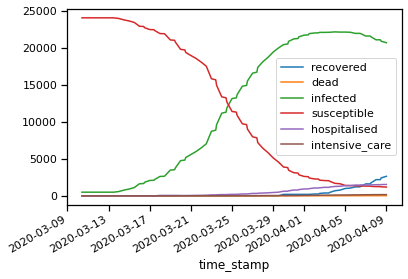

In [29]:
world_df.plot()
plt.legend()

In [36]:
area_df = read.super_area_summary()

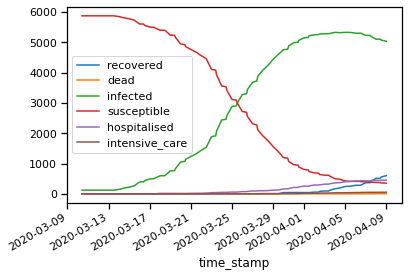

In [37]:
area_df[area_df.super_area == 'E02002560'].plot()
plt.legend()

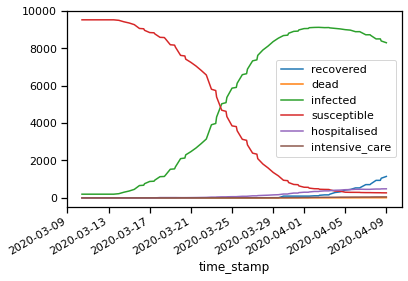

In [38]:
area_df[area_df.super_area == 'E02001720'].plot()
plt.legend()

In [39]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

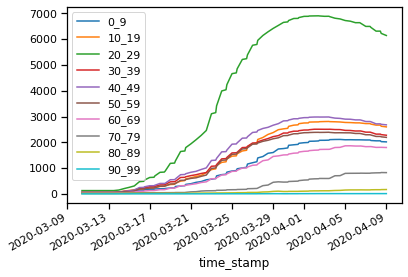

In [40]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
plt.legend()

In [41]:
random_trajectories = read.draw_random_trajectories(100)

Text(0.5, 0, 'Date')

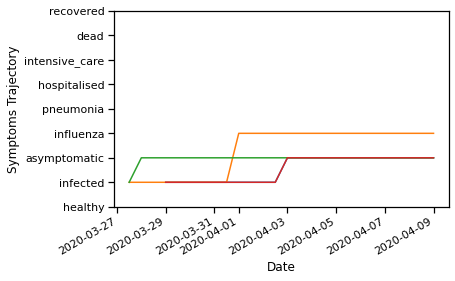

In [42]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
symptoms = ['healthy','infected', 'asymptomatic',
            'influenza','pneumonia', 'hospitalised',
           'intensive_care', 'dead', 'recovered']
_ = plt.yticks(range(len(symptoms)), symptoms)
plt.xlabel('Date')

In [43]:
outputs = ReadLogger.from_logger(simulator.logger)

In [99]:
%%time
daily_df = outputs.daily_to_dataframe()

CPU times: user 15.4 s, sys: 28.5 ms, total: 15.4 s
Wall time: 15.6 s


In [101]:
len(outputs.daily_dict)

83

In [98]:
daily_df.loc['2020-03-10']

,area,infected_f_0_4,recovered_f_0_4,susceptible_f_0_4,hospitalised_f_0_4,intensive_care_f_0_4,dead_f_0_4,infected_f_5_18,recovered_f_5_18,susceptible_f_5_18,...,susceptible_m_30_64,hospitalised_m_30_64,intensive_care_m_30_64,dead_m_30_64,infected_m_65_99,recovered_m_65_99,susceptible_m_65_99,hospitalised_m_65_99,intensive_care_m_65_99,dead_m_65_99
time_stamp,,,,,,,,,,,,,,,,,,,,,
2020-03-10 00:00:00,E00062207,0,0,7,0,0,0,1,0,15,...,75,0,0,0,1,0,18,0,0,0
2020-03-10 00:00:00,E00062382,0,0,7,0,0,0,0,0,18,...,57,0,0,0,0,0,19,0,0,0
2020-03-10 00:00:00,E00062386,0,0,3,0,0,0,0,0,17,...,56,0,0,0,0,0,31,0,0,0
2020-03-10 00:00:00,E00062385,0,0,4,0,0,0,0,0,18,...,89,0,0,0,2,0,52,0,0,0
2020-03-10 00:00:00,E00062380,0,0,4,0,0,0,0,0,12,...,41,0,0,0,0,0,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-10 12:00:00,E00042446,0,0,2,0,0,0,0,0,13,...,26,0,0,0,0,0,6,0,0,0
2020-03-10 12:00:00,E00042475,0,0,0,0,0,0,0,0,5,...,22,0,0,0,0,0,1,0,0,0
2020-03-10 12:00:00,E00042447,0,0,3,0,0,0,0,0,1,...,29,0,0,0,0,0,1,0,0,0


In [44]:
daily_df = outputs.world_full_summary()
age_df = outputs.world_per_age()

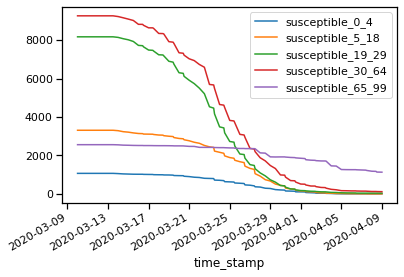

In [95]:
age_df.filter(regex='susceptible*').plot()

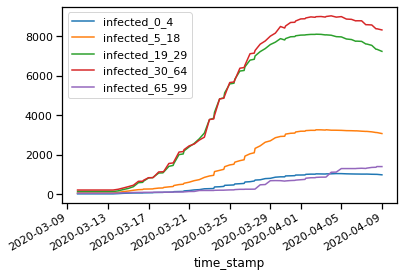

In [46]:
age_df.filter(regex='infected*').plot()

In [47]:
short_df = outputs.world_short_summary()

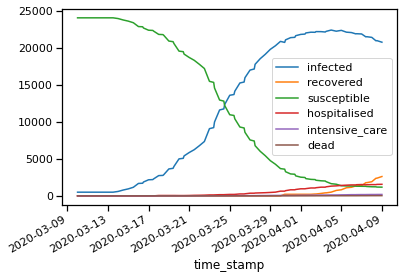

In [48]:
short_df.plot()

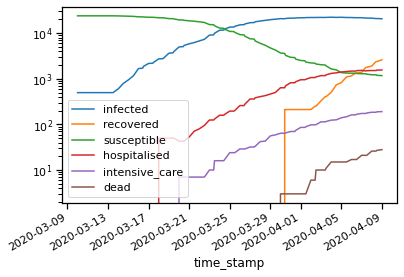

In [49]:
short_df.plot(logy=True)

In [53]:
n_pubs = len(world.pubs.members)

In [80]:
def get_number_buildings(location):
    plural = location.name + 's'
    if location.name == 'grocery':
        plural = 'groceries'
    elif location.name == 'company':
        plural = 'companies'
    elif location.name == 'commute_unit':
        plural = 'commuteunits'
    elif location.name == 'commutecity_unit':
        plural = 'commutecityunits'
    return len(getattr(world, plural).members)
    

In [81]:
simulator.world.commuteunits

In [86]:
locations_df = outputs.locations_to_dataframe()


In [87]:
locations_df['n_buildings'] = locations_df.apply(
    lambda x: get_number_buildings(x),
    axis=1)

In [88]:
locations_df['average'] = locations_df['location'] / locations_df['n_buildings']


Text(0, 0.5, 'Number of infections at location')

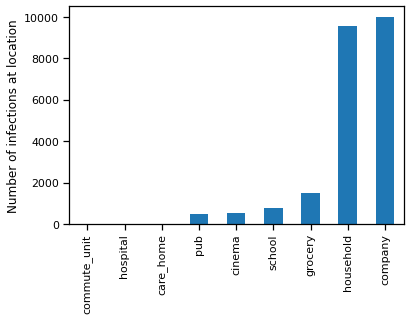

In [92]:
locations_df['location'].sort_values().plot.bar()
plt.ylabel('Number of infections at location')

Text(0, 0.5, 'Number of average infections at location')

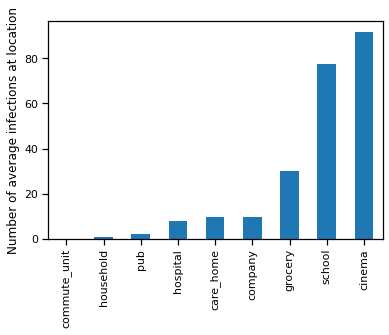

In [91]:

locations_df['average'].sort_values().plot.bar()
plt.ylabel('Number of average infections at location')

In [27]:
trajectories_df = outputs.trajectories_to_dataframe()

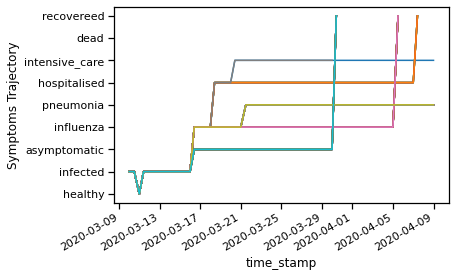

In [49]:

for key, df_person in trajectories_df.groupby('ID'):
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
symptoms = ['healthy','infected', 'asymptomatic',
            'influenza','pneumonia', 'hospitalised',
           'intensive_care', 'dead', 'recovereed']
_ = plt.yticks(range(len(symptoms)), symptoms)

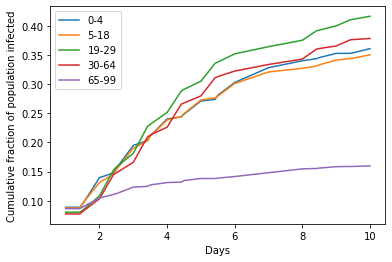

In [27]:
fig = simulator.logger.plot_cumulative_fraction()

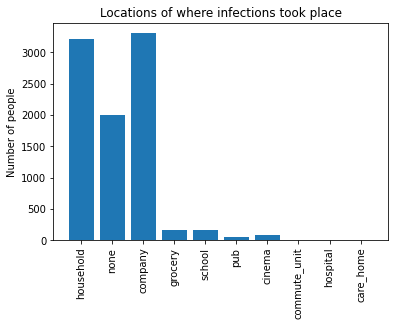

In [29]:
fig = simulator.logger.plot_infection_location()


In [ ]:
fig = simulator.logger.plot_R()
#TODO: Needs to be fixed